In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import joblib
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve

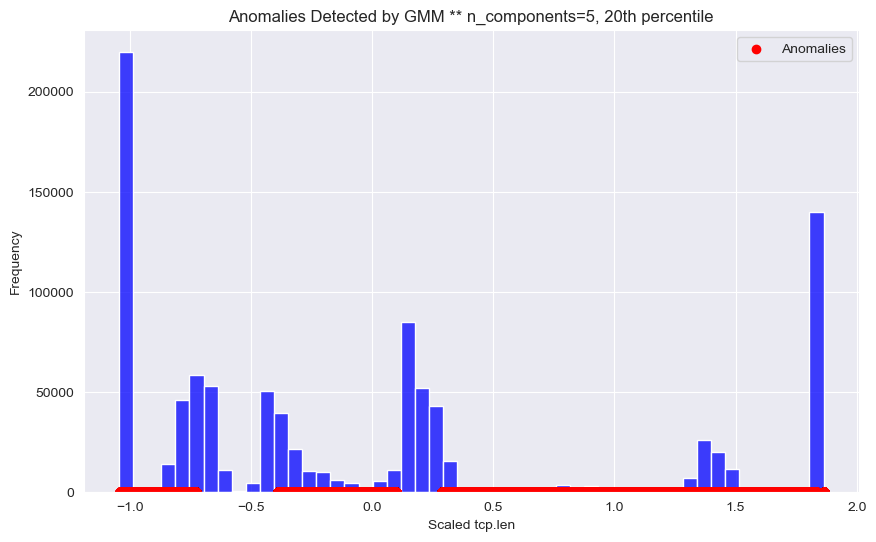

In [32]:
df = joblib.load('df_chosen_features.csv')

scaler = StandardScaler()
df['tcp.len_scaled'] = scaler.fit_transform(df[['tcp.len']])

# dropping NaN rows
df = df.dropna(subset=['tcp.len_scaled'])

# Fitting the Gaussian Mixture Model with different parameters

# Initialize GMM
gmm = GaussianMixture(n_components=5,
                      covariance_type='full',
                      max_iter=200,
                      n_init=5,
                      init_params='kmeans',
                      random_state=0)

# Fit the model
gmm.fit(df[['tcp.len_scaled']])

# Predict the labels
labels = gmm.predict(df[['tcp.len_scaled']])

# Calculate log-likelihood of each sample
log_likelihood = gmm.score_samples(df[['tcp.len_scaled']])

# Set a threshold for anomaly detection --> keep this the same as before
threshold = np.percentile(log_likelihood, 30)

# Flag anomalies
df['anomaly'] = log_likelihood < threshold

# Visualization and Analysis
plt.figure(figsize=(10, 6))
sns.histplot(df['tcp.len_scaled'],
             bins=50,
             kde=False,
             color='blue')


anomalies = df[df['anomaly']]
plt.scatter(anomalies['tcp.len_scaled'],
            [0] * len(anomalies),
            color='red',
            label='Anomalies')
plt.legend()
plt.title('Anomalies Detected by GMM ** n_components=5, 20th percentile')
plt.xlabel('Scaled tcp.len')
plt.ylabel('Frequency')
plt.show()

In [33]:
filepath = "attack-sample.csv"
df_original = pd.read_csv(filepath)
sub_df_original = df_original.loc[:, ['tcp.len', 'alert']]
sub_df_original = sub_df_original.dropna(subset=['tcp.len'])

sub_df_original['anomaly'] = df['anomaly']

TP = ((sub_df_original['alert'] == 'suspicious') & (sub_df_original['anomaly'] == True)).sum()
FP = ((sub_df_original['alert'] == 'benign') & (sub_df_original['anomaly'] == True)).sum()
FN = ((sub_df_original['alert'] == 'suspicious') & (sub_df_original['anomaly'] == False)).sum()

precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0

print(f'Precision is: {precision} \nRecall is: {recall}')

/tmp/ipykernel_404703/3124113793.py:2: DtypeWarning: Columns (34,37,44,50,52,54,70,71) have mixed types. Specify dtype option on import or set low_memory=False.
  df_original = pd.read_csv(filepath)


Precision is: 0.9977566596024359 
Recall is: 0.298704179993294


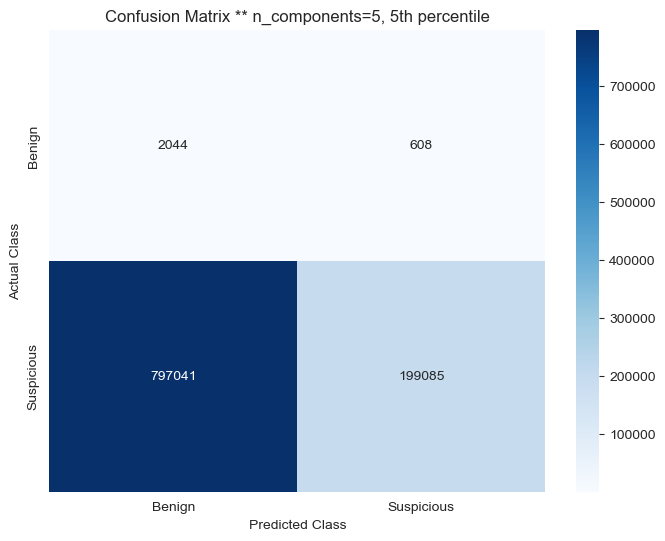

In [14]:
true_labels = (sub_df_original['alert'] == 'suspicious').astype(int)

# Convert boolean 'anomaly' flags to binary format
predicted_labels = sub_df_original['anomaly'].astype(int)

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)


plt.figure(figsize=(8, 6))
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=['Benign', 'Suspicious'],
            yticklabels=['Benign', 'Suspicious'])
plt.title('Confusion Matrix ** n_components=5, 5th percentile')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()


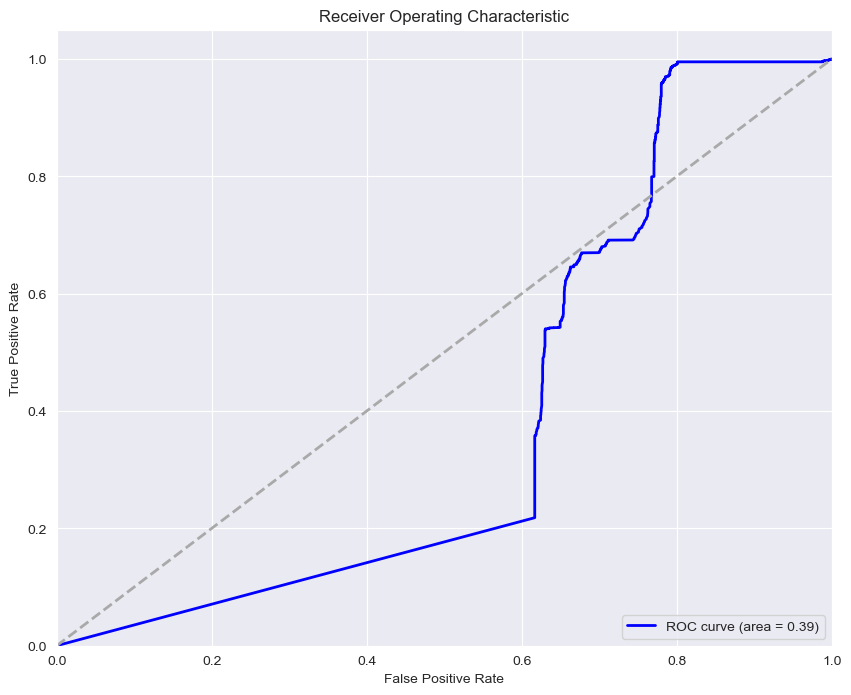

In [15]:
fpr, tpr, thresholds = roc_curve(true_labels, log_likelihood)

roc_auc = roc_auc_score(true_labels, log_likelihood)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='darkgrey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

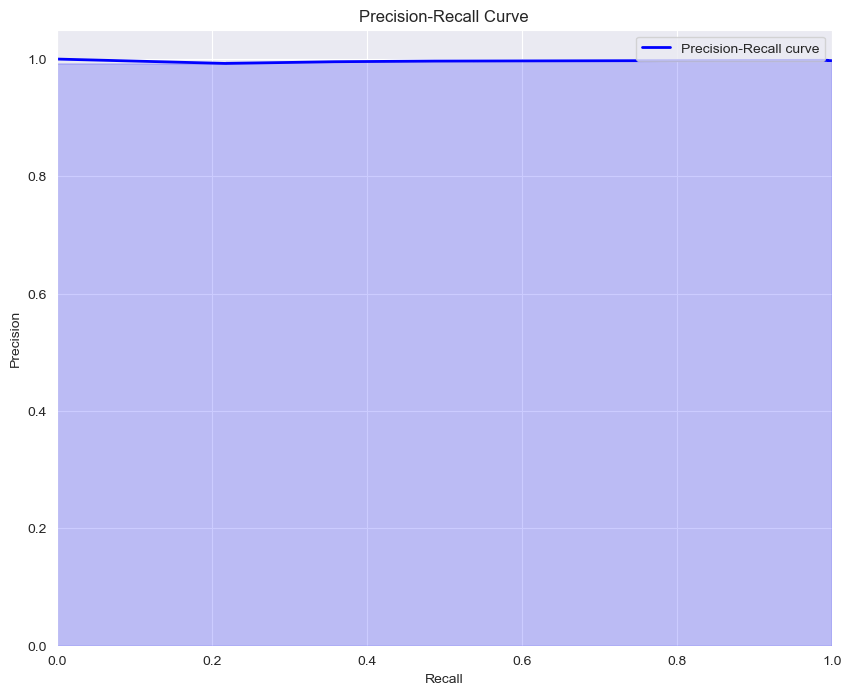

In [16]:
precision, recall, threshold2s = precision_recall_curve(true_labels, log_likelihood)

plt.figure(figsize=(10, 8))
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend(loc="upper right")
plt.show()


Changes I have tried:
- Added the number of components to 5 --> no change in the precision/recall
- n_components=5,
                      covariance_type='full',
                      max_iter=200,
                      n_init=5,
                      init_params='kmeans',
                      random_state=0) --> no change in the precision/recall
- Adjust the Decision Threshold: kept above but increased the threshold: threshold = np.percentile(log_likelihood, 10) --> a little bit better recall --> Precision is: 0.9940379349023333 & Recall is: 0.09875156355722067
- n_components=5, changed the covariance_type to ‘tied’: all components share the same general covariance matrix. got the same recall: Precision is: 0.9992039597897637
Recall is: 0.09828776680861658
- init_params='k-means++'  made it much worse -->Precision is: 0.0 and Recall is: 0.0
- init_params= 'random' -->Precision is: 0.0 and Recall is: 0.0
- n_components=5,
                      covariance_type='diag',
                      max_iter=200,
                      n_init=5,
                      init_params='kmeans',
                      random_state=0 --> Precision is: 0.9940379349023333 and Recall is: 0.09875156355722067
- kept above, changed the threshold to 20 and I'm getting higher recall: Precision is: 0.996955326426064 and Recall is: 0.19985925475291277
- Changed the threshold to 30 and got higher recall Precision is: 0.9977566596024359 and Recall is: 0.298704179993294
- I'm not comfortable to increase the threshold more than this